In [2]:
!pip install numpy==1.23
# !pip install overpass
# !pip install OSMPythonTools
# !pip install scikit-image
# !pip install geopy
# !pip install levenshtein
# !pip install cykhash==1.0.2
# !pip install pyrosm



  Obtaining dependency information for numpy==1.23 from https://files.pythonhosted.org/packages/86/65/fe6f20a40d05fc909cab9c3c17f259b03a1fbf87a6b3a7b92ca0376582e8/numpy-1.23.0-cp310-cp310-macosx_10_9_x86_64.whl.metadata
  Using cached numpy-1.23.0-cp310-cp310-macosx_10_9_x86_64.whl.metadata (2.2 kB)
Using cached numpy-1.23.0-cp310-cp310-macosx_10_9_x86_64.whl (18.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.3
    Uninstalling numpy-2.2.3:
      Successfully uninstalled numpy-2.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
econml 0.14.0 requires scikit-learn<1.2,>0.22.0, but you have scikit-learn 1.3.0 which is incompatible.
gtfs2nx 0.2.0 requires numpy<2.0.0,>=1.25.2, but you have numpy 1.23.0 which is incompatible.
gtfs2nx 0.2.0 requires pandas<3.0.0,>=2.0.3, but you have pandas 1.5.3 which is incompatible.
hpsklearn 1.0

In [10]:
import os
import sys
import logging
import warnings
import pickle
import urllib.request 
import json
import traceback
import datetime
import glob
from pathlib import Path


import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import rasterio.plot
import rasterio.mask
from shapely.geometry import Point, MultiPolygon, Polygon, LineString, MultiLineString, GeometryCollection
from shapely.geometry import box
import uci

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', '..', 'global-mode-shares')
sys.path.append(PROJECT_SRC_PATH)
from global_mode_shares.osm import LocalOSM, OverpassOSM
from global_mode_shares import overture, guide
import global_mode_shares.raster as rtr

pd.set_option("display.max_columns", None)


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
warnings.resetwarnings()
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning, message='A scalar was specified but there are multiple treatments')


In [16]:
# from importlib import reload
# reload(logging)

logging.basicConfig(level=logging.INFO, format='%(asctime)s | %(levelname)s | %(funcName)s - %(message)s', datefmt='%I:%M:%S')
logger = logging.getLogger(__name__)

## Data

In [ ]:
# Convert multi-layer GeoPackage to GeoParquet

# gpk_path = '../data/GHS_UCDB_GLOBE_R2024A.gpkg'
# gdf_list = [gpd.read_file(gpk_path, layer=layer) for layer in fiona.listlayers(gpk_path)]
# gdf_list_wo = gdf_list[:1] + [gdf.drop(columns='geometry') for gdf in gdf_list[1:]]
# urban_areas_2024 = pd.concat(gdf_list_wo, axis=1)
# urban_areas_2024 = urban_areas_2024.loc[:, ~urban_areas_2024.columns.duplicated()]
# urban_areas_2024.to_parquet('../data/GHS_UCDB_GLOBE_R2024A.parquet')

In [26]:
aux_cols = ['GHS_urban_area_id', 'GHS_urban_area', 'GHS_country', 'GHS_region', 'geometry']
vars_of_interest = ['GHS_population', 'GHS_population_density', 'GHS_GDP_PPP', 'GHS_built_up_area_pc', 'GHS_population_growth', 'GHS_population_density_growth', 'GHS_GDP_PPP_growth', 'GHS_built_up_area_pc_growth', 'GHS_urban_sprawl']


In [27]:
def compound_annual_growth_rate(start, end, periods):
    return ((end/start)**(1/periods) - 1) * 100


vars_2019 = {
    'ID_HDC_G0': 'GHS_urban_area_id',
    'UC_NM_MN': 'GHS_urban_area',
    'UC_NM_LST': 'GHS_urban_area_cities',
    'CTR_MN_NM': 'GHS_country',
    'GRGN_L1': 'GHS_region',
    'GRGN_L2': 'GHS_subregion',
    'CTR_MN_ISO': 'GHS_country_code',
    'SDG_A2G14': 'GHS_green_access',
    'E_GR_AV14': 'GHS_greeness',
    'P15': 'GHS_population',
    'BUCAP15': 'GHS_built_up_area_pc',
    'SDG_OS15MX': 'GHS_open_spaces',
    'SDG_LUE9015': 'GHS_urban_sprawl',
    'GDP15_SM': 'GHS_total_GDP',
    'E_WR_P_14': 'GHS_rain',
    'E_WR_T_14': 'GHS_temperature',
    'EX_HW_IDX': 'GHS_heatwaves',
    'E_KG_NM_LST': 'GHS_climate_class',
    'EL_AV_ALS': 'GHS_elevation',
    'DEV_CMI': 'UN_development_group',
    'INCM_CMI': 'UN_income_class',
}

urban_areas_2019 = gpd.read_parquet('../data/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.parquet')

urban_areas_2019['GHS_population_growth'] = compound_annual_growth_rate(urban_areas_2019['P00'], urban_areas_2019['P15'], 15)
urban_areas_2019['GHS_GDP_PPP'] = urban_areas_2019['GDP15_SM'] / urban_areas_2019['P15']
urban_areas_2019['GHS_GDP_PPP_growth'] = compound_annual_growth_rate(urban_areas_2019['GDP00_SM'] / urban_areas_2019['P00'], urban_areas_2019['GDP15_SM'] / urban_areas_2019['P15'], 15)
urban_areas_2019['GHS_built_up_area_pc_growth'] = compound_annual_growth_rate(urban_areas_2019['BUCAP00'], urban_areas_2019['BUCAP15'], 15)
urban_areas_2019['GHS_population_density'] = urban_areas_2019['P15'] / urban_areas_2019['B15']
urban_areas_2019['GHS_population_density_growth'] = compound_annual_growth_rate(urban_areas_2019['P00'] / urban_areas_2019['B00'], urban_areas_2019['P15'] / urban_areas_2019['B15'], 15)

urban_areas_2019['ID_HDC_G0'] = urban_areas_2019['ID_HDC_G0'].astype(int)

urban_areas_2019 = urban_areas_2019.rename(columns=vars_2019)[vars_of_interest + aux_cols]


In [32]:
vars_2024 = {
    'ID_UC_G0': 'GHS_urban_area_id',
    'GC_UCN_MAI_2025': 'GHS_urban_area',
    'GC_UCN_LIS_2025': 'GHS_urban_area_cities',
    'GC_CNT_GAD_2025': 'GHS_country',
    'GC_DEV_USR_2025': 'GHS_region',
    'SD_LUE_LPR_2000_2020': 'GHS_urban_sprawl',
    'GH_BPC_TOT_2025': 'GHS_built_up_area_pc',
    'GH_BPC_CAG_2000_2025': 'GHS_built_up_area_pc_growth',
    'GH_POP_TOT_2025': 'GHS_population',
    'GH_POP_CAG_2000_2025': 'GHS_population_growth',
    'GH_POP_DEN_2025': 'GHS_population_density',
    'GH_PD_CAG_2000_2025': 'GHS_population_density_growth',
    'GH_GDP_CAG_2000_2020': 'GHS_GDP_PPP_growth',
    'GC_DEV_WIG_2025': 'GHS_development_group',
    'EX_L05_SHP_2025': 'GHS_flood_exposure',
}

urban_areas_2024 = gpd.read_parquet('../data/GHS_UCDB_GLOBE_R2024A.parquet')

urban_areas_2024['GHS_population_growth'] = compound_annual_growth_rate(urban_areas_2024['GH_POP_TOT_2000'], urban_areas_2024['GH_POP_TOT_2025'], 25)
urban_areas_2024['GHS_GDP_PPP_growth'] = compound_annual_growth_rate(urban_areas_2024['SC_SEC_GDP_2000'], urban_areas_2024['SC_SEC_GDP_2020'], 20)
urban_areas_2024['GHS_built_up_area_pc_growth'] = compound_annual_growth_rate(urban_areas_2024['GH_BPC_TOT_2000'], urban_areas_2024['GH_BPC_TOT_2025'], 25)

urban_areas_2024['GHS_population_density'] = urban_areas_2024['GH_POP_TOT_2025'] / (urban_areas_2024['GH_BUS_TOT_2025'] / 1000 / 1000)
urban_areas_2024['GHS_population_density_2000'] = urban_areas_2024['GH_POP_TOT_2000'] / (urban_areas_2024['GH_BUS_TOT_2000'] / 1000 / 1000)
urban_areas_2024['GHS_population_density_growth'] = compound_annual_growth_rate(urban_areas_2024['GHS_population_density_2000'], urban_areas_2024['GHS_population_density'], 25)

urban_areas_2024['GHS_GDP_PPP'] = urban_areas_2024['SC_SEC_GDP_2020'] * (urban_areas_2024.area / 1e6) / urban_areas_2024['GH_POP_TOT_2025']

urban_areas_2024['ID_UC_G0'] = urban_areas_2024['ID_UC_G0'].astype(int)
urban_areas_2024['SD_LUE_LPR_2000_2020'] = urban_areas_2024['SD_LUE_LPR_2000_2020'].replace({'<-5': '-5', '>5': '5'}).astype(float)
urban_areas_2024['GHS_flood_exposure_cat'] = (urban_areas_2024['EX_L05_SHP_2025'] > 0.05).astype(int)

urban_areas_2024 = urban_areas_2024.rename(columns=vars_2024)[vars_of_interest + aux_cols]

In [33]:
country_continent_mapping = pd.read_csv('../data/GADM_country_continent_mapping.csv')
urban_areas_2024['continent'] = urban_areas_2024['GHS_country'].map(country_continent_mapping.set_index('COUNTRY')['CONTINENT'])

# urban_areas_2024_all = urban_areas_2024.copy()
# urban_areas_2024 = urban_areas_2024[urban_areas_2024['continent'] != 'Oceania']

In [28]:
var_labels = {
    'GHS_country': 'Country',
    'GHS_region': 'Region',
    'GHS_urban_sprawl': 'Urban sprawl (land use efficiency)',
    'GHS_built_up_area_pc': 'Built-up area per capita [m2/person]',
    'GHS_built_up_area_pc_growth': 'Built-up area per capita growth',
    'GHS_population': 'Population [people]',
    'GHS_population_growth': 'Population growth',
    'GHS_population_density': 'Population density [people/km2]',
    'GHS_population_density_growth': 'Population density growth',
    'GHS_GDP_PPP': "GDP (PPP) per capita [int'l $]",
    'GHS_GDP_PPP_growth': 'GDP (PPP) per capita growth',
    'GHS_development_group': 'World Bank income group',
    'GHS_flood_exposure': 'Low Elevated Coastal Zone (LECZ)',
}

## Feature engineering

In [42]:
def download_OSM_data(cities, buffer=0):
    other_names = {
        'ireland': 'ireland_and_northern_ireland',
        'israel': 'israel_and_palestine',
        'malaysia': 'malaysia_singapore_brunei',
        'puerto_rico': 'puerto_rico',
        'singapore': 'malaysia_singapore_brunei',
        'united_kingdom': 'great_britain', # any northern irish cities included?
        'united_states': 'usa'
        }
    
    # Determining Geofabrik dataset names
    cities['osm_dataset'] = cities['GHS_country'].str.lower().str.replace(' ', '_').replace(other_names)
    cities.loc[cities['GHS_country'] == 'United States', 'osm_dataset'] = cities['state_name'].str.lower() # download state-level OSM datasets for U.S. due to memory limitations

    # pyrosm does not find california, but only northern & southern california. Download manually instead
    # Download all US states manually (pyrosm downloads weird small versions, which do not include all data)
    for state in cities.loc[cities['GHS_country'] == 'United States', 'osm_dataset']:
        filepath = os.path.join(LocalOSM.DIR, state + '.osm.pbf')
        url = f"https://download.geofabrik.de/north-america/us/{state.replace(' ', '-')}-latest.osm.pbf"
        if not os.path.isfile(filepath):
            logger.info(f'Downloading OSM Geofabrik file for {state}...')
            urllib.request.urlretrieve(url, filepath)

    # Download Geofabrik country .pbf files
    cities['osm_dataset'].apply(LocalOSM.get_dataset)

    # Extracting city areas with buffer from country .pbf files
    crs = cities.crs
    cities['geometry_buffer'] = cities.geometry.to_crs(3035).buffer(buffer).to_crs(crs)
    cities.apply(lambda x: LocalOSM.extract_area_to_pbf(x['osm_dataset'], x['geometry_buffer'], x['GHS_urban_area']), axis=1)


def categorize_places(places, category_file):
    with open(category_file, 'r') as file:
        categories_map = json.load(file)

    # categories_map = {v: k for k, vals in categories.items() for v in vals}
    main_category = places['category'].map(categories_map).fillna('others')
    return main_category


def _persist(data, city):
    with open(f'../data/montfort-preprocessed-data/{city}.pkl', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


def _load(city):
    try:
        with open(f'../data/montfort-preprocessed-data/{city}.pkl', 'rb') as handle:
            return pickle.load(handle)
    except FileNotFoundError:
        return None


def calculate_bike_lane_road_ratio(roads, bike_lanes):
    road_length = roads.unary_union.length
    bike_lanes_length = bike_lanes.unary_union.length

    return bike_lanes_length / road_length



def tif_to_gdf(tif_file, geometries=None):
    if geometries is None:
        with rasterio.open(tif_file) as src:
            raster_data = src.read(1)
            gdf = raster_to_gdf(raster_data, src)
    else:
        raster_data, meta = rtr.read_area(tif_file, geometries)
        gdf = raster_to_gdf(raster_data[0], meta)

    return gdf


def raster_to_gdf(raster_data, meta):
    height, width = raster_data.shape
    rows, cols = np.meshgrid(np.arange(width), np.arange(height))

    xs, ys = rasterio.transform.xy(meta['transform'], cols, rows, offset='center')
    xs = np.array(xs).flatten()
    ys = np.array(ys).flatten()

    geom = gpd.points_from_xy(xs, ys)
    values = pd.Series(raster_data.flatten(), name='values')
    gdf = gpd.GeoDataFrame(values, geometry=geom, crs=meta['crs'])

    return gdf


def gdf_to_db(db, gdf, res):
    """
    Attention: Converting raster data to hexagonal grid by assigning raster cell centroids to hexagons and summing up the values only works if resolution of hexagonal grid is significantly larger so that each hexagon covers a comparable number of raster cells.
    """
    gdf = gdf.to_crs('EPSG:4326')
    gdf['lat'] = gdf.geometry.y
    gdf['lon'] = gdf.geometry.x
    gdf = gdf.drop(columns='geometry')
    
    db.execute("CREATE TABLE IF NOT EXISTS population_h3 (h3 BIGINT PRIMARY KEY, population INTEGER)")
    sql = f"""
        INSERT OR REPLACE INTO population_h3
        SELECT 
            h3_latlng_to_cell(lat, lon, {res}) AS h3,
            SUM(values) AS population
        FROM gdf
        GROUP BY h3
    """
    db.register("gdf", gdf)
    db.execute(sql)


# def correlation_between_population_and_pois(db):
#     sql = """
#         SELECT u.name, 
#         corr(p.population, c.n_pois) AS correlation_coefficient 
#         FROM population_h3 p
#         LEFT JOIN counts_h3 c ON p.h3 = c.h3
#         LEFT JOIN city_h3 u ON p.h3 = u.h3
#         GROUP BY u.id, u.name
#         ORDER BY correlation_coefficient DESC;
#     """
#     df = db.execute(sql).df()
#     return df

def correlation_between_population_and_pois(db, city):
    sql = f"""
        SELECT corr(p.population, c.n_pois) AS correlation_coefficient 
        FROM city_h3 u
        JOIN population_h3 p ON u.h3 = p.h3
        JOIN counts_h3 c ON u.h3 = c.h3
        WHERE u.id = {city};
    """
    corr = db.execute(sql).fetchall()[0][0]
    return corr


def calculate_urban_centrality(db, city):
    sql = f"""
        SELECT 
            h3_h3_to_string(h3_cell_to_parent(p.h3, 8)) AS parent_h3, 
            SUM(p.population) AS total_population, 
        FROM city_h3 u
        JOIN population_h3 p ON u.h3 = p.h3
        WHERE u.id = {city}
        GROUP BY parent_h3
    """
    df = db.execute(sql).df()
    gdf = df.set_index('parent_h3').dropna().h3.h3_to_geo_boundary()

    metric_crs = gdf.estimate_utm_crs()
    gdf = gdf.to_crs(metric_crs)

    centrality = uci.uci.uci(gdf, var_name='total_population', euclidean=True, bootstrap_border=False)

    return centrality['UCI']


def preprocess_city(poi_db, categories_file, population_file, elevation_file, hdd_file, cdd_file, city, country, city_geometry, buffer):
    data = {}
    crs = city_geometry.crs
    lon = city_geometry.centroid.x.values[0]
    lat = city_geometry.centroid.y.values[0]
    city_geometry_buffer = city_geometry.to_crs(3035).buffer(buffer).to_crs(crs)

    logger.info('Reading gridded population data...')
    population, city_meta = rtr.read_area(population_file, city_geometry_buffer)
    data['population'] = rtr.mask_with_geometry(population[0], city_geometry, city_meta) # first band

    gdf = raster_to_gdf(data['population'], city_meta)
    gdf_to_db(poi_db, gdf.dropna(), 8)

    # logger.info('Querying & rasterizing POIs from Overture...')
    # places = overture.get_places(poi_db, city_geometry_buffer)
    # places['main_category'] = categorize_places(places, categories_file)
    # data |= rtr.rasterize_by_category(places, city_meta)

    # logger.info('Querying & rasterizing rail stations from OSM...')
    # # # osm = OverpassOSM(area_geom=city_geometry_buffer)
    # osm = LocalOSM(city)
    # rail_stations = osm.fetch_rail_stations()
    # data['rail'] = rtr.rasterize(rail_stations, city_meta)

    # logger.info('Querying & rasterizing roads and bike paths from OSM...')
    # data['roads'] = osm.fetch_roads()
    # data['bike_lanes'] = osm.fetch_bike_lanes()
    # data['bike'] = rtr.rasterize_bike_lanes(data['bike_lanes'], city_meta)

    # logger.info('Querying & rasterizing urban greenery from OSM...')
    # greenery = osm.fetch_greenery()
    # data['greenery'] = rtr.rasterize_greenery(greenery, city_meta)

    # logger.info('Querying & rasterizing elevation within built-up area...')
    # elevation, city_meta = rtr.read_area(elevation_file, city_geometry_buffer)
    # built_up = osm.fetch_built_up_area()
    # data['elevation_built_up'] = rtr.mask_with_geometry(elevation, built_up, city_meta, all_touched=True)

    logger.info('Looking up heating & cooling degree days...')
    data['hdd'] = rtr.read_value(hdd_file, lon, lat)
    data['cdd'] = rtr.read_value(cdd_file, lon, lat)

    # logger.info('Looking up gas price...')
    # gas_prices = pd.read_csv('../data/gasoline-prices-countries.csv')
    # local_price = gas_prices[gas_prices['country'] == country]['gas_price_euro'].values[0]
    # data['gas_price'] = local_price

    return data


def calculate_city_features(data, db, city):
    # population = data['population']

    # FEATURE: high-density neighborhoods
    # high_density_mask_50 = np.ma.masked_less(population, 50)
    # share_high_density_50 = rtr.share_of_people(population, high_density_mask_50)
    # high_density_mask_100 = np.ma.masked_less(population, 100)
    # share_high_density_100 = rtr.share_of_people(population, high_density_mask_100)
    # high_density_mask_150 = np.ma.masked_less(population, 150)
    # share_high_density_150 = rtr.share_of_people(population, high_density_mask_150)

    # FEATURE: Mixed-use
    mixed_use_coeff = correlation_between_population_and_pois(db, city)

    # FEATURE: Urban centrality
    centrality = calculate_urban_centrality(db, city)

    # # FEATURE: healthcare accessibility
    # if not 'healthcare' in data:
    #     health_access = 0
    # else:
    #     health_access = rtr.share_of_people_near(population, data['healthcare'], distance=10, minimum=5)

    # # FEATURE: shops accessibility
    # if not 'shops_and_services' in data:
    #     shops_access = 0
    # else:
    #     shops_access = rtr.share_of_people_near(population, data['shops_and_services'], distance=5, minimum=10)

    # # FEATURE: education accessibility
    # if not 'education' in data:
    #     education_access = 0
    # else:
    #     education_access = rtr.share_of_people_near(population, data['education'], distance=10, minimum=3)

    # # FEATURE: third places accessibility
    # if not 'third_places' in data:
    #     third_places_access = 0
    # else:
    #     third_places_access = rtr.share_of_people_near(population, data['third_places'], distance=5, minimum=10)

    # # FEATURE: other places accessibility
    # if not 'others' in data:
    #     other_places_access = 0
    # else:
    #     other_places_access = rtr.share_of_people_near(population, data['others'], distance=5, minimum=10)

    # # FEATURE: average local accessibility
    # local_access = np.mean([health_access, shops_access, education_access, third_places_access, other_places_access])

    # # FEATURE: urban greenery accessibility
    # greenery_access = rtr.share_of_people_near(population, data['greenery'], distance=2, minimum=1)
    
    # # FEATURE: rail-based transit accessibility
    # transit_access = rtr.share_of_people_near(population, data['rail'], distance=7, minimum=1)
    
    # # FEATURE: bike lanes coverage
    # bike_lane_coverage = rtr.share_of_people_near(population, data['bike'], distance=2, minimum=1)
    # bike_lane_road_ratio = calculate_bike_lane_road_ratio(data['roads'], data['bike_lanes'])
    
    # # FEATURE: ruggedness of built-up area
    # ruggedness = rtr.ruggedness(data['elevation_built_up'])

    # FEATURE: heating & cooling degree days
    hdd = data['hdd']
    cdd = data['cdd']

    # # FEATURE: gas price
    # gas_price = data['gas_price']

    fts = {
        # 'high_density_50': share_high_density_50,
        # 'high_density_100': share_high_density_100,
        # 'high_density_150': share_high_density_150,
        'mixed_use': mixed_use_coeff,
        'uci': centrality,
        # 'health_access': health_access,
        # 'shops_access': shops_access,
        # 'education_access': education_access,
        # 'third_places_access': third_places_access,
        # 'other_places_access': other_places_access,
        # 'local_access': local_access,
        # 'greenery_access': greenery_access,
        # 'transit_access': transit_access,
        # 'bike_lane_coverage': bike_lane_coverage,
        # 'bike_lane_road_ratio': bike_lane_road_ratio,
        # 'ruggedness': ruggedness,
        'hdd': hdd,
        'cdd': cdd,
        # 'gas_price': gas_price,
    }

    return fts


def preprocessing(cities, db, categories_file, population_file, elevation_file, hdd_file, cdd_file, buffer, update=True):
    for index, row in cities.iterrows():
        city = row['GHS_urban_area']
        id = row['GHS_urban_area_id']
        country = row['GHS_country']
        geometry = cities.geometry.loc[[index]]  # keep geometry as GeoSeries to use utilities like .to_crs() etc.

        try:
            data = _load(id) or {}
            
            if not data or update:
                logger.info(f'Processing city {city} ({id})...')
                data |= preprocess_city(db, categories_file, population_file, elevation_file, hdd_file, cdd_file, city, country, geometry, buffer)
                _persist(data, id)
            else:
                logger.info(f'Skipping {city} ({id}), city already preprocessed.')

        except Exception as e:
            logger.warning(f'City {city} ({id}) failed: {e}')
            time = datetime.datetime.now()
            with open(f'../logs/{id}-{type(e).__name__}-{time:%Y-%m-%d_%H:%M:%S}.log', 'a') as f:
                f.write(str(e))
                f.write(traceback.format_exc())


def feature_engineering(cities, db):
    fts = {}
    for id, city in zip(cities['GHS_urban_area_id'], cities['GHS_urban_area']):
        logger.info(f'Calculating features for city {city}...')
        data = _load(id)

        if not data:
            logger.warning(f'City {city} (id {id}) not preprocessed yet. Skipping.')
            continue
        
        try:
            fts[id] = calculate_city_features(data, db, id)
        except Exception as e:
            logger.warning(f'City {city} failed: {traceback.format_exc()}')

    fts_df = pd.DataFrame(index=fts.keys(), data=fts.values())
    fts_df['name'] = cities.set_index('GHS_urban_area_id')['GHS_urban_area']
    
    return fts_df
    

def feature_engineering_all(db):
    fts = {}
    for f in glob.glob("../data/montfort-preprocessed-data/*.pkl"):
        city = Path(f).stem
        data = _load(city)
        try:
            fts[city] = calculate_city_features(data, db, city)
        except Exception as e:
            logger.warning(f'City {city} failed: {traceback.format_exc()}')
        else:
            logger.info(f'City {city} succeeded.')

    fts_df = pd.DataFrame(index=fts.keys(), data=fts.values())
    
    return fts_df


In [38]:
hdd_file = '../../global-mode-shares/data/HDD_historical_mean_v1.nc'
cdd_file = '../../global-mode-shares/data/CDD_historical_mean_v1.nc'
    
    # lon = city_geometry.centroid.x.values[0]
    # lat = city_geometry.centroid.y.values[0]    
    # data['hdd'] = rtr.read_value(hdd_file, lon, lat)
    # data['cdd'] = rtr.read_value(cdd_file, lon, lat)

urban_areas_2024['hdd'] = urban_areas_2024.to_crs('EPSG:4326').centroid.apply(lambda x: rtr.read_value(hdd_file, x.x, x.y))
logger.info('Sucess hdd')
urban_areas_2024['cdd'] = urban_areas_2024.to_crs('EPSG:4326').centroid.apply(lambda x: rtr.read_value(cdd_file, x.x, x.y))
logger.info('Sucess cdd')


/var/folders/jk/rndbblbs2fs0_symsqry30400000gn/T/ipykernel_20482/2630434006.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  urban_areas_2024['hdd'] = urban_areas_2024.to_crs('EPSG:4326').centroid.apply(lambda x: rtr.read_value(hdd_file, x.x, x.y))
08:15:33 | WARNING | read_value - Value at lat -13.833, lon -171.783 is NaN. Calculating average over 3x3 grid around location.
/Users/fnachtigall/workspace/global-urban-typology/notebooks/../../global-mode-shares/global_mode_shares/raster.py:128: RuntimeWarning: Mean of empty slice
  value = np.nanmean(values)
08:15:33 | WARNING | read_value - Value at lat -21.144, lon -175.203 is NaN. Calculating average over 3x3 grid around location.
08:15:33 | WARNING | read_value - Value at lat 21.324, lon -158.017 is NaN. Calculating average over 3x3 grid around location.
08:15:33 | WARNING | read_value - Value

In [ ]:
urban_areas_2024

In [41]:
urban_areas_2024.to_parquet('../data/GHS_UCDB_2024_preproc_2025_04_03.parquet')

In [ ]:
categories_file = '../data/overture/classified-places-chatgpt.json'
population_density_tif_global = '../data/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0.tif' # Global
elevation_tif = '../data/gmted2010-mea075.tif'
hdd_file = '../data/HDD_historical_mean_v1.nc'
cdd_file = '../data/CDD_historical_mean_v1.nc'


sample_cities = ['Berlin', 'Marseille', 'Lyon', 'Leipzig', 'Frankfurt am Main', 'Madrid', 'Leeds', 'Athens', 'Addis Ababa', 'Cape Town', 'Nairobi', 'Detroit', 'Houston', 'Phoenix', 'Los Angeles', 'San Francisco', 'Mumbai', 'Shanghai']
# sample_cities = ['Berlin', 'Marseille', 'Lyon', 'Leipzig', 'Frankfurt am Main', 'Leeds', 'Addis Ababa', 'Nairobi', 'Cape Town', 'Shanghai']
# sample_cities = ['Kiel', 'Marseille']
buffer = 1000
update = True

# logger.info('Initializing Overture places databse...')
db = overture.init_db()
# overture.init_places(db)

# logger.info('Loading urban areas...')
# cities_all = load_urban_areas()

cities = urban_areas_2019
# cities = cities_all.sample(n=10, random_state=42)
# cities = cities_all[cities_all['GHS_urban_area'].isin(sample_cities)]


# logger.info('Downloading and extracting OSM data for cities...')
# download_OSM_data(cities, buffer)

# logger.info('Preprocessing cities...')
# preprocessing(cities, db, categories_file, population_density_tif_global, elevation_tif, hdd_file, cdd_file, buffer, update)

logger.info('Feature engineering...')
fts_df = feature_engineering(cities, db)
# new_fts_df = feature_engineering_all(db)


# # # logger.info('Saving features...')
fts_df.to_csv('../data/montfort-preprocessed-data/features.csv')

fts_df


08:23:42 | INFO | <module> - Feature engineering...
08:23:42 | INFO | feature_engineering - Calculating features for city Honolulu...
08:23:42 | INFO | feature_engineering - Calculating features for city Papeete...
08:23:42 | INFO | feature_engineering - Calculating features for city Santa Maria...
08:23:42 | INFO | feature_engineering - Calculating features for city Monterey...
08:23:42 | INFO | feature_engineering - Calculating features for city Santa Barbara...
08:23:42 | INFO | feature_engineering - Calculating features for city Santa Cruz...
08:23:43 | INFO | feature_engineering - Calculating features for city Salinas...
08:23:43 | INFO | feature_engineering - Calculating features for city Oxnard...
08:23:43 | INFO | feature_engineering - Calculating features for city Watsonville...
08:23:43 | INFO | feature_engineering - Calculating features for city San Jose...
08:23:45 | INFO | feature_engineering - Calculating features for city Camarillo...
08:23:45 | INFO | feature_engineerin

In [22]:

def _load(city):
    try:
        with open(f'../data/montfort-preprocessed-data/{city}.pkl', 'rb') as handle:
            return pickle.load(handle)
    except FileNotFoundError:
        return None


_load(100)

{'hdd': 551.9304,
 'cdd': 1118.9757,
 'population': masked_array(
   data=[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],
   mask=[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],
   fill_value=1e+20)}

In [187]:
cities['GHS_subregion'].value_counts()

South-Central Asia       4272
Eastern Asia             2111
Eastern Africa           1050
South-Eastern Asia        875
Western Africa            804
South America             736
Northern Africa           512
Western Asia              479
Eastern Europe            420
Northern America          372
Middle Africa             350
Central America           266
Southern Europe           230
Western Europe            227
Northern Europe           182
Southern Africa            89
Caribbean                  74
Melanesia                  50
Australia/New Zealand      35
Polynesia                   1
Name: GHS_subregion, dtype: int64

<Axes: xlabel='hdd', ylabel='Density'>

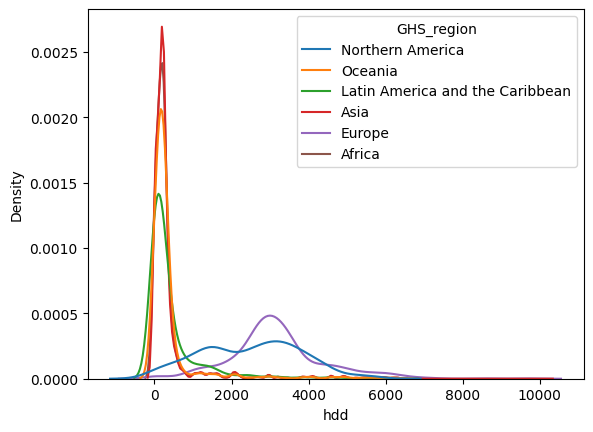

In [192]:
cities_hdd = cities.merge(fts_df, left_on='GHS_urban_area', right_on='name')
# cities_hdd[cities_hdd['GHS_region'] != 'Asia'].groupby('GHS_region')['hdd'].hist(bins=20, legend=True)
# sns.histplot(cities_hdd, x='hdd', hue='GHS_region', stat="probability", common_norm=False, bins=20)
sns.kdeplot(cities_hdd, x='hdd', hue='GHS_region', common_norm=False)


In [162]:
fts_df['uci'].dropna()

1        0.076816
2        0.083859
3        0.049568
4        0.060007
5        0.046846
           ...   
13131    0.000000
13132    0.137815
13133    0.053414
13134    0.088338
13135    0.074386
Name: uci, Length: 13068, dtype: float64

In [40]:
import json
with open('../data/15-min-paper-accessibility.json', 'r') as f:
    accessibility_15_min_paper = json.load(f)

walk_access = {city['city'].title(): float(city['avg_foot']) for city in accessibility_15_min_paper if city['city'].title() in sample_cities}
fts_df['walk_access'] = fts_df['name'].map(walk_access)
fts_df

df = fts_df.dropna(subset='walk_access').set_index('name')
df['walk_access'].corr(df['mixed_use'])


-0.6903064883867608

GHS_urban_area_id GHS_urban_area GHS_urban_area_cities  \
1                      2        Papeete               Papeete   
2                      3    Santa Maria           Santa Maria   
3                      4       Monterey              Monterey   
4                      5  Santa Barbara         Santa Barbara   
5                      6     Santa Cruz            Santa Cruz   
...                  ...            ...                   ...   
13127              13128         Kokopo                Kokopo   
13130              13131       Tauranga              Tauranga   
13131              13132           Buin                  Buin   
13132              13133        Honiara               Honiara   
13133              13134         Nouméa                Nouméa   

            GHS_country        GHS_region          GHS_subregion  \
1      French Polynesia           Oceania              Polynesia   
2         United States  Northern America       Northern America   
3         United States  Northern America       Northern America   
4         United States  Northern America       Northern America   
5         United States  Northern America       Northern America   
...                 ...               ...                    ...   
13127  Papua New Guinea           Oceania              Melanesia   
13130       New Zealand           Oceania  Australia/New Zealand   
13131  Papua New Guinea           Oceania              Melanesia   
13132   Solomon Islands           Oceania              Melanesia   
13133     New Caledonia           Oceania              Melanesia   

      GHS_country_code  GHS_green_access  GHS_greeness  GHS_population  \
1                  PYF          0.284119      0.436477    91521.124603   
2                  USA          0.040129      0.312846   123181.284843   
3                  USA          0.138683      0.358101    67772.288858   
4                  USA          0.061348      0.362785   114753.150167   
5                  USA          0.109287      0.353734   101498.145565   
...                ...               ...           ...             ...   
13127              PNG          0.641936      0.595116    69403.226654   
13130              NZL          0.409358      0.424533    84583.724382   
13131              PNG          1.000000           NaN    65360.369141   
13132              SLB          0.824672      0.500063    73669.684235   
13133              NCL          0.080976      0.372020    70631.796295   

       GHS_built_up_area_pc  GHS_open_spaces  GHS_urban_sprawl  GHS_total_GDP  \
1                158.361614              NaN           0.12800   0.000000e+00   
2                340.967420            23.64           0.48114   4.174295e+09   
3                409.599122            42.17           0.44484   1.998786e+09   
4                332.032274            36.50           0.55676   4.159702e+09   
5                339.980601            39.46           0.31759   3.890861e+09   
...                     ...              ...               ...            ...   
13127             16.721701              NaN           2.58870   9.288849e+07   
13130            374.746317            54.71           0.23856   1.773777e+09   
13131              1.683696              NaN           4.13980   1.447689e+06   
13132             55.241734            82.30           1.74730   1.022208e+08   
13133            171.477555            55.15           0.25381   0.000000e+00   

          GHS_rain  GHS_temperature  GHS_heatwaves  \
1      1536.075012        22.021633            NaN   
2       245.175001        14.718191        2.79174   
3       324.925007        15.274110            NaN   
4       183.925007        15.376907        4.25502   
5       324.925007        15.274110        1.51970   
...            ...              ...            ...   
13127  2311.000000        26.766257        3.52734   
13130  1627.649994        13.888477       14.05370   
13131  3982.000000        26.631417        1.81968   
13132  

In [156]:
city = 'Uspantán'

ids = cities[cities['GHS_population'].between(100000, 200000)]['GHS_urban_area_id'].sample(100)
city_id = cities[cities['GHS_urban_area'] == city]['GHS_urban_area_id'].values[0]
for id in ids:

    sql = f"""
        SELECT 
            h3_h3_to_string(h3_cell_to_parent(p.h3, 8)) AS parent_h3, 
            SUM(p.population) AS total_population, 
        FROM city_h3 u
        JOIN population_h3 p ON u.h3 = p.h3
        WHERE u.id = {id}
        GROUP BY parent_h3
    """
    df = db.execute(sql).df()
    print(len(df))
    gdf = df.set_index('parent_h3').dropna().h3.h3_to_geo_boundary()

    metric_crs = gdf.estimate_utm_crs()
    gdf = gdf.to_crs(metric_crs)

    centrality_bf = uci.uci.uci(gdf, var_name='total_population', euclidean=True, bootstrap_border=True)
    centrality_bt = uci.uci.uci(gdf, var_name='total_population', euclidean=True, bootstrap_border=False)

    print((centrality_bt['UCI'] - centrality_bf['UCI']).round(3))


56
-0.016
42
-0.016
29
-0.007
31
-0.02
21
-0.027
4
0.005
83
-0.044
25
-0.05
5
0.049
11
-0.002
38
-0.025
34
-0.015
67
-0.022
52
-0.011
18
-0.004
62
-0.017
56
-0.031
11
-0.019
91
-0.01
11
-0.007
34
-0.004
10
-0.076
61
-0.024
21
-0.011
61
-0.037
63
-0.013
5
0.04
108
-0.014
32
-0.011
79
-0.014
13
-0.037
41
-0.031
43
-0.032
12
-0.043
37
-0.014
29
-0.004
75
-0.021
72
-0.02
2


/usr/local/Caskroom/miniconda/base/envs/playground/lib/python3.10/site-packages/uci/uci.py:182: RuntimeWarning: invalid value encountered in divide
  return vec / np.sum(vec)


ValueError: zero-size array to reduction operation maximum which has no identity

In [13]:
db = overture.init_db()
# overture.init_h3_grid(db, cities, 8)


In [42]:
import pyarrow.parquet as pq
import pyarrow as pa
import duckdb


def correlation_between_population_and_pois(db):
    sql = """
        SELECT u.name, 
        corr(p.population, c.n_pois) AS correlation_coefficient 
        FROM population_h3 p
        LEFT JOIN counts_h3 c ON p.h3 = c.h3
        LEFT JOIN city_h3 u ON p.h3 = u.h3
        GROUP BY u.id, u.name
        ORDER BY correlation_coefficient DESC;
    """
    df = db.execute(sql).df()
    return df

# population_density_tif_global = '../data/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0.tif'
# city = 'Berlin'
# sample_cities = ['Berlin', 'Marseille', 'Lyon', 'Leipzig', 'Frankfurt am Main', 'Madrid', 'Leeds', 'Athens', 'Addis Ababa', 'Cape Town', 'Nairobi', 'Detroit', 'Houston', 'Phoenix', 'Los Angeles', 'San Francisco', 'Mumbai', 'Shanghai']
# for city in sample_cities:
#     gdf = tif_to_gdf(population_density_tif_global, cities[cities['GHS_urban_area'] == city].geometry)
#     gdf_to_db(db, gdf.dropna(), 8)


correlation_between_population_and_pois(db)

# population, city_meta = rtr.read_area(population_density_tif_global, cities[cities['GHS_urban_area'] == city].geometry)
# gdf = raster_to_gdf(population[0], city_meta, point=True)


# db.execute("DROP TABLE population_h3")
# db.execute("SELECT population, h3_h3_to_string(h3) as h3 FROM population_h3").df().set_index('h3').h3.h3_to_geo_boundary().explore('population')


# df = duckdb.from_df({"lat": ys, "lon": xs, "population": values})

# Ingest into DuckDB while converting to H3 and aggregating





# population_hex = gdf.to_crs('EPSG:4326').h3.geo_to_h3_aggregate(8, 'sum')
# population_hex.explore('values')


name  correlation_coefficient
0       San Francisco                 0.806210
1              Berlin                 0.723594
2           Marseille                 0.713883
3              Madrid                 0.705246
4              Mumbai                 0.701324
5                Lyon                 0.675196
6             Leipzig                 0.668970
7   Frankfurt am Main                 0.667737
8              Athens                 0.558597
9            Shanghai                 0.302141
10              Leeds                 0.293892
11        Los Angeles                 0.272464
12            Houston                 0.180076
13        Addis Ababa                 0.150983
14            Detroit                 0.102284
15            Phoenix                 0.059473
16            Nairobi                -0.024175
17          Cape Town                -0.071666
18               None                      NaN

In [44]:
pd.read_csv('../data/preprocessed-data/features.csv')


Unnamed: 0  high_density  health_access  shops_access  \
0            Turin     91.847347      91.798456     90.754696   
1        Milwaukee     35.892403      80.149131     68.792649   
2    Dar es Salaam     92.189833      21.331043     14.991917   
3          Seattle     32.965641      64.996532     51.461783   
4            Basel     65.794964      78.361168     75.528485   
..             ...           ...            ...           ...   
359      Allentown     40.571464      76.771094     62.868637   
360          Miami     42.548566      78.845574     63.765664   
361       Santa Fe     90.268719      73.211891     82.996589   
362      Knoxville     27.433200      64.906841     68.617446   
363         Yakima     29.549140      81.988533     72.514564   

     education_access  third_places_access  other_places_access  \
0           89.996945            82.522851            84.643483   
1           82.547584            55.393767            40.466811   
2           50.041094             5.590948             6.225629   
3           72.686046            49.013871            43.053989   
4           78.859764            52.530128            80.633884   
..                ...                  ...                  ...   
359         72.970954            53.601387            46.483824   
360         80.324939            55.753527            48.510799   
361         88.003035            44.188870            57.031638   
362         70.439110            60.570183            38.698864   
363         77.987817            59.243630            52.313761   

     greenery_access  transit_access  bike_lane_coverage  \
0          88.280538       63.012057           60.554337   
1          55.466366        0.985814           14.827432   
2          23.735471       10.330336           10.451975   
3          66.239696        7.902380           49.170632   
4          62.214039       65.647075           46.839461   
..               ...             ...                 ...   
359        46.833032        0.000000           15.813591   
360        28.856175        4.351995           19.486057   
361        53.643031        0.000000           15.974459   
362        49.221413        3.730144           27.241073   
363        23.237798        8.170625           11.352687   

     bike_lane_road_ratio  ruggedness        hdd         cdd  gas_price  \
0                0.302135   51.961681  3434.5293   174.03459      1.832   
1                0.063579   25.788754  3609.6235   461.67258      0.903   
2                0.173462   27.166706     0.0000  3002.67460      1.078   
3                0.341020   50.225331  3067.4797   146.37985      0.903   
4                0.378655   36.989056  3112.1338   232.07380      1.944   
..                    ...         ...        ...         ...        ...   
359              0.101276   19.719358  2739.3164   723.11190      0.903   
360              0.197171    2.531518   137.1245  2461.29220      0.903   
361              0.098673    3.152716   860.1636  1254.34900      1.056   
362              0.234745   27.555123  1996.1702   928.61755      0.903   
363              0.151006   32.699326  3784.0280   311.61400      0.903   

     local_access  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
..            ...  
359           NaN  
360           NaN  
361           NaN  
362           NaN  
363           NaN  

[364 rows x 16 columns]

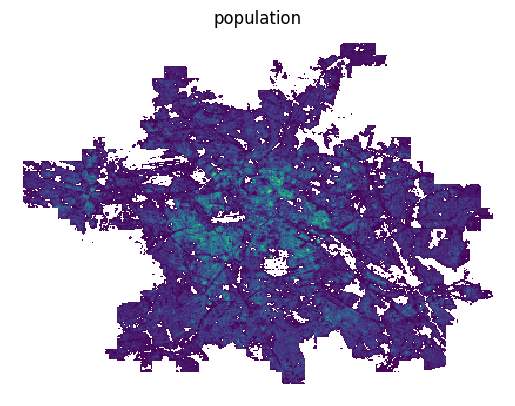

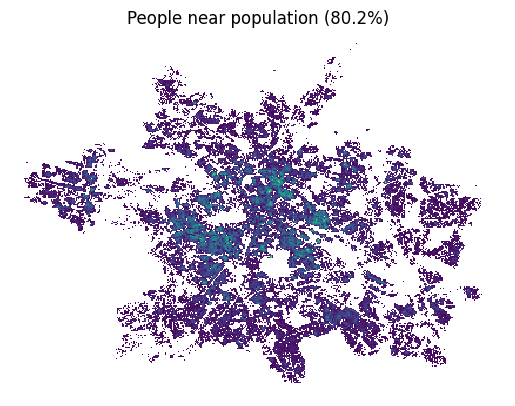

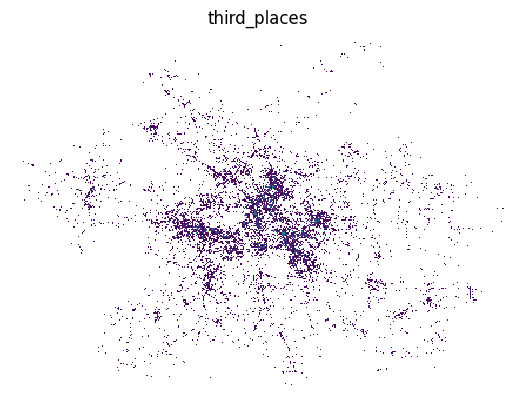

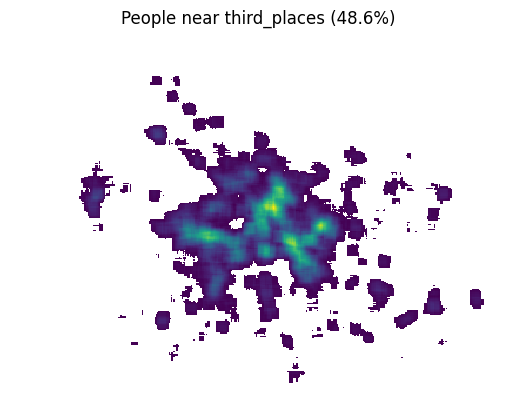

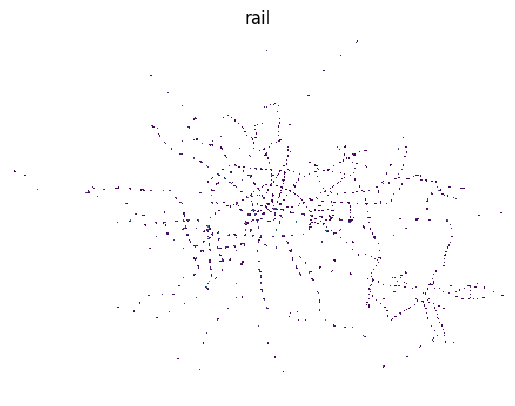

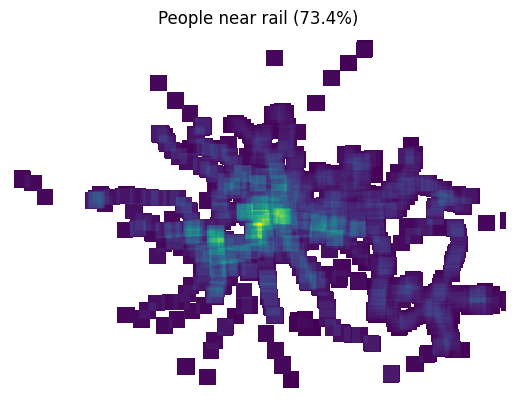

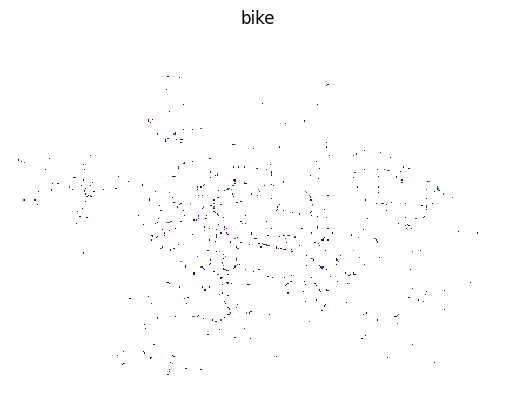

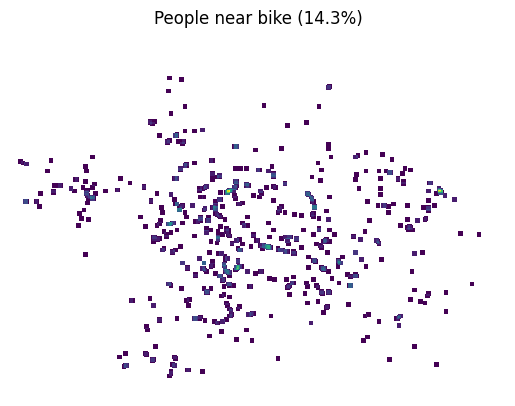

In [57]:
city = 'Berlin'
population, city_meta = rtr.read_area(population_density_tif_global, cities[cities['GHS_urban_area'] == city].geometry)
data = _load(city)

distance = {
    'third_places': 5,
    'rail': 7,
    'bike': 2,
    'greenery': 2,
}
minimum = {
    'third_places': 10,
    'rail': 1,
    'bike': 1,
    'greenery': 1,
}

for ft in ['population', 'third_places', 'rail', 'bike']:
    filtered = np.ma.masked_less(data[ft], 1)
    plt.imshow(filtered, cmap='viridis', interpolation='none')
    plt.title(ft)
    plt.axis('off')
    plt.show()

    if ft == 'population':
        filtered = np.ma.masked_less(data[ft], 50)

    else:
        pooled = rtr.sum_pooling(data[ft], block_size=distance[ft]*2)
        filtered = np.ma.masked_less(pooled, minimum[ft])
        
    share = rtr.share_of_people(data['population'], filtered)
    plt.imshow(filtered, cmap='viridis', interpolation='none')
    plt.title(f'People near {ft} ({share:.1f}%)')
    plt.axis('off')
    plt.show()



(-0.5, 421.5, 309.5, -0.5)

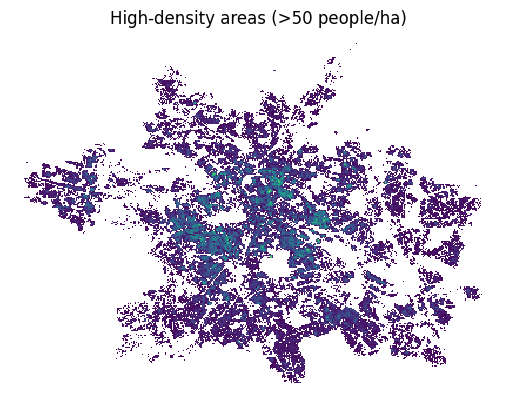

In [49]:
high_density_mask_50 = np.ma.masked_less(data['population'], 50)
rtr.share_of_people(data['population'], high_density_mask_50)
plt.imshow(high_density_mask_50, cmap='viridis', interpolation='none')
plt.title('High-density areas (>50 people/ha)')
plt.axis('off')

In [113]:
import uci

from skimage.measure import block_reduce

def pool(data, meta, pool_size, func):

    pooled_height = data.shape[0] // pool_size[0]
    pooled_width = data.shape[1] // pool_size[1]

    def masked_func(block, **kwargs):
        masked_block = np.ma.masked_array(block, mask=(block == -200)) # don't know why it is 200 and not data.fill_value which is 1e+20
        return func(masked_block, **kwargs)
    
    pooled = block_reduce(data, block_size=pool_size, func=masked_func)
    pooled = np.ma.masked_array(pooled, mask=(pooled == 0), fill_value=-200)

    pooled_transform = meta['transform'] * meta['transform'].scale(
        (meta['width'] / pooled_width),
        (meta['height'] / pooled_height)
    )

    meta['transform'] = pooled_transform
    meta['height'] = pooled_height
    meta['width'] = pooled_width

    return pooled, meta


cities = cities_all.copy()
ucis_new = {}
# for city in ['Paris', 'Rio de Janeiro', 'San Jose', 'Munich', 'Berlin', 'Leipzig', 'New York', 'Philadelphia', 'Phoenix', 'Colorado Springs', 'Toronto', 'Barcelona', 'Thessaloniki', 'Porto']:
# for city in ['Berlin', 'Paris', 'Phoenix', 'Rio de Janeiro']:
for city in ['Berlin', 'Marseille', 'Lyon', 'Leipzig', 'Frankfurt am Main', 'Madrid', 'Leeds', 'Athens', 'Addis Ababa', 'Cape Town', 'Nairobi', 'Detroit', 'Houston', 'Phoenix', 'Los Angeles', 'San Francisco', 'Mumbai', 'Shanghai']:

    # population, city_meta = rtr.read_area(population_density_tif_global, cities[cities['GHS_urban_area'] == 'San Jose'].to_crs(paris_pop_gdf.crs).centroid.buffer(10000))
    population, city_meta = rtr.read_area(population_density_tif_global, cities[cities['GHS_urban_area'] == city].geometry)
    # data = _load(city)
    # if not data:
    #     continue

    # population, city_meta = pool(population[0], city_meta, (10, 10), np.ma.sum)
    # gdf_pop = raster_to_gdf(population[0], city_meta)
    # print(gdf_pop.dropna())
    # gdf_pop = gdf_pop.h3.geo_to_h3_aggregate(6, 'sum', return_geometry=False).h3.h3_to_geo()
    # gdf_pop = gdf_pop.h3.geo_to_h3_aggregate(8, 'sum', return_geometry=True)
    

    # sql = f"""
    #     SELECT h3_cell_to_parent(h3) AS parent_h3, h3_cell_to_lat(h3) AS lat, h3_cell_to_lon(h3) AS lon, SUM(population) AS population
    #     FROM population_h3
    #     WHERE h3 IN (SELECT h3 FROM city_h3 WHERE id = {city})
    #     GROUP BY h3

    sql = f"""
        SELECT 
            h3_h3_to_string(h3_cell_to_parent(p.h3, 7)) AS parent_h3, 
            SUM(p.population) AS values, 
        FROM city_h3 u
        JOIN population_h3 p ON u.h3 = p.h3
        WHERE u.name = '{city}'
        GROUP BY parent_h3
    """
    gdf_pop = db.execute(sql).df()
    gdf_pop = gdf_pop.set_index('parent_h3').h3.h3_to_geo_boundary()
    print(city)
    print(gdf_pop['values'].sum())
    if gdf_pop['values'].sum() == 0:
        continue
    ucis_new[city] = uci.uci.uci(gdf_pop.dropna().to_crs(gdf_pop.estimate_utm_crs()), var_name='values', euclidean=True, bootstrap_border=True)
    # ax = gdf_pop.plot('values', figsize=(4, 4))
    # ax.set_title(city)
    # ax.set_axis_off()


pd.DataFrame(ucis_new).T

Berlin
3473774.0
Marseille
914638.0
Lyon
1176724.0
Leipzig
527779.0
Frankfurt am Main
1106407.0
Madrid
5719355.0
Leeds
1340679.0
Athens
3226193.0
Addis Ababa
5583894.0
Cape Town
4028913.0
Nairobi
5028858.0
Detroit
3274426.0
Houston
5678472.0
Phoenix
4069110.0
Los Angeles
14737491.0
San Francisco
54095.0
Mumbai
22865535.0
Shanghai
27960621.0


UCI  location_coef  proximity_index  \
Berlin             0.123896       0.312205         0.396842   
Marseille          0.230378       0.465735         0.494655   
Lyon               0.203795       0.419494         0.485812   
Leipzig            0.122210       0.340633         0.358772   
Frankfurt am Main  0.134181       0.333852         0.401918   
Madrid             0.191859       0.456252         0.420510   
Leeds              0.088434       0.292132         0.302720   
Athens             0.192984       0.401572         0.480571   
Addis Ababa        0.177795       0.394408         0.450791   
Cape Town          0.140386       0.380361         0.369086   
Nairobi            0.180448       0.444023         0.406393   
Detroit            0.094973       0.265746         0.357385   
Houston            0.099972       0.318230         0.314149   
Phoenix            0.076577       0.276902         0.276551   
Los Angeles        0.092790       0.315257         0.294332   
San Francisco      0.086815       0.327376         0.265183   
Mumbai             0.139095       0.522447         0.266237   
Shanghai           0.221330       0.458208         0.483035   

                   spatial_separation  spatial_separation_max  
Berlin                   20054.745491            33249.554427  
Marseille                 9236.290879            18277.212629  
Lyon                      9576.369640            18624.270844  
Leipzig                   9406.576447            14669.635000  
Frankfurt am Main        15698.937294            26248.809523  
Madrid                   17455.139361            30121.575717  
Leeds                    19626.025588            28146.528859  
Athens                   11949.959838            23005.942043  
Addis Ababa               9339.585683            17005.510460  
Cape Town                15852.111487            25125.639461  
Nairobi                   9776.324469            16469.347122  
Detroit                  34286.191448            53354.160764  
Houston                  35916.694559            52368.057296  
Phoenix                  33699.462803            46581.642649  
Los Angeles              53209.192652            75402.633912  
San Francisco             2616.792870             3561.148754  
Mumbai                   20988.136135            28603.421593  
Shanghai                 26408.613062            51083.935244

In [101]:
pd.DataFrame(ucis_new).T

UCI  location_coef  proximity_index  \
Berlin             0.117175       0.312205         0.375315   
Marseille          0.212966       0.465735         0.457268   
Lyon               0.190708       0.419494         0.454614   
Leipzig            0.122668       0.340633         0.360116   
Frankfurt am Main  0.110021       0.333852         0.329549   
Madrid             0.178227       0.456252         0.390633   
Leeds              0.081605       0.292132         0.279341   
Athens             0.175401       0.401572         0.436786   
Addis Ababa        0.151814       0.394408         0.384915   
Cape Town          0.125209       0.380361         0.329184   
Nairobi            0.162657       0.444023         0.366325   
Detroit            0.090162       0.265746         0.339278   
Houston            0.095561       0.318230         0.300288   
Phoenix            0.067054       0.276902         0.242158   
Los Angeles        0.080002       0.315257         0.253768   
San Francisco      0.070138       0.327376         0.214242   
Mumbai             0.115878       0.522447         0.221798   
Shanghai           0.213542       0.458208         0.466036   

                   spatial_separation  spatial_separation_max  
Berlin                   20054.745491            32103.748836  
Marseille                 9236.290879            17018.137542  
Lyon                      9576.369640            17558.889481  
Leipzig                   9406.576447            14700.450453  
Frankfurt am Main        15698.937294            23415.477383  
Madrid                   17455.139361            28644.710828  
Leeds                    19626.025588            27233.449042  
Athens                   11949.959838            21217.434340  
Addis Ababa               9339.585683            15184.225525  
Cape Town                15852.111487            23631.081320  
Nairobi                   9776.324469            15427.990546  
Detroit                  34286.191448            51892.002808  
Houston                  35916.694559            51330.701244  
Phoenix                  33699.462803            44467.649282  
Los Angeles              53209.192652            71303.832320  
San Francisco             2616.792870             3330.276417  
Mumbai                   20988.136135            26970.038011  
Shanghai                 26408.613062            49457.690302

In [112]:
sql = f"""
    WITH parent_h3_data AS (
        SELECT 
            h3_cell_to_parent(p.h3, 7) AS parent_h3, 
            SUM(p.population) AS total_population, 
        FROM city_h3 u
        JOIN population_h3 p ON u.h3 = p.h3
        WHERE u.name = 'Detroit'
        GROUP BY parent_h3
    )
    SELECT 
        h3_h3_to_string(parent_h3) as h3,
        h3_cell_to_lat(parent_h3) AS lat,
        h3_cell_to_lng(parent_h3) AS lon,
        total_population, 
    FROM parent_h3_data
"""
gdf_pop = db.execute(sql).df()
gdf_pop = gdf_pop.set_index('h3').h3.h3_to_geo_boundary()
uci.uci.uci(gdf_pop.dropna(), var_name='total_population', euclidean=True, bootstrap_border=True)
gdf_pop.explore('total_population')

In [ ]:
fts_df = pd.read_csv('../data/montfort-preprocessed-data/features.csv', index_col=0)

# fts_df.update(new_fts_df)
# new_columns = new_fts_df.columns.difference(fts_df.columns)
# fts_df[new_columns] = new_fts_df[new_columns]
# fts_df

In [524]:
cities_w_fts['local_access'] = cities_w_fts[['shops_access', 'health_access', 'education_access', 'third_places_access', 'other_places_access']].mean(axis=1)

In [ ]:
fts_df = pd.read_csv('../data/montfort-preprocessed-data/features.csv', index_col=0)
# cities_w_fts = pd.merge(cities, fts_df, left_on='GHS_urban_area', right_index=True, how='left')
cities_w_fts = pd.merge(cities, fts_df, left_on='GHS_urban_area', right_index=True, how='right')
cities_w_fts

CityID   ObsID    year LastObservation           City  \
812.0  M10715  ID0585  2011.0             YES         Torino   
863.0  M10473    C232  2019.0             YES      Milwaukee   
953.0  M10177  ID0146  2018.0             YES  Dar Es Salaam   
934.0  M10653    C319  2019.0             YES        Seattle   
348.0  M10059  ID0050  2015.0             YES          Basel   
...       ...     ...     ...             ...            ...   
803.0  M10020    C009  2019.0             YES      Allentown   
957.0  M10470    C228  2019.0             YES          Miami   
730.0  M10643  ID0534  2012.0             YES       Santa Fe   
805.0  M10370    C187  2019.0             YES      Knoxville   
465.0  M10786    C381  2019.0             YES         Yakima   

                                             metro_names        Country  \
812.0                                             Torino          Italy   
863.0       Milwaukee-Waukesha-West Allis, WI Metro Area  United States   
953.0                                      Dar Es Salaam       Tanzania   
934.0             Seattle-Tacoma-Bellevue, WA Metro Area  United States   
348.0                                              Basel    Switzerland   
...                                                  ...            ...   
803.0       Allentown-Bethlehem-Easton, PA-NJ Metro Area  United States   
957.0  Miami-Fort Lauderdale-West Palm Beach, FL Metr...  United States   
730.0                                           Santa Fe      Argentina   
805.0                           Knoxville, TN Metro Area  United States   
465.0                              Yakima, WA Metro Area  United States   

           continent                       region         subregion  \
812.0         Europe                       Europe   Southern Europe   
863.0  North America                North America  Northern America   
953.0         Africa           Sub-Saharan Africa    Eastern Africa   
934.0  North America                North America  Northern America   
348.0         Europe                       Europe    Western Europe   
...              ...                          ...               ...   
803.0  North America                North America  Northern America   
957.0  North America                North America  Northern America   
730.0  South America  Latin America and Caribbean     South America   
805.0  North America                North America  Northern America   
465.0  North America                North America  Northern America   

         state_name state_abbr  population   longitude   latitude   Walking  \
812.0           NaN        NaN    900000.0    7.674000  45.088000  0.070000   
863.0     Wisconsin         WI   1546202.0  -88.007031  43.016681  0.026797   
953.0           NaN        NaN   5325879.0   39.210000  -6.830000       NaN   
934.0    Washington         WA   3513620.0 -122.320460  47.744732  0.040462   
348.0           NaN        NaN    169464.0    7.589000  47.555000  0.333333   
...             ...        ...         ...         ...        ...       ...   
803.0  Pennsylvania         PA    817821.0  -75.444096  40.651646  0.024010   
957.0       Florida         FL   5713638.0  -80.329536  25.794738  0.016687   
730.0           NaN        NaN    570000.0  -60.705335 -31.628988  0.400000   
805.0     Tennessee         TN    838775.0  -83.920739  35.960638       NaN   
465.0    Washington         WA    242624.0 -120.505899  46.602071  0.017297   

        Cycling    Active       Bus       Car          IncomeGroup  \
812.0  0.010000  0.080000  0.280000  0.640000          High income   
863.0  0.003654  0.030451  0.020706  0.948843          High income   
953.0       NaN  0.450000  0.430000  0.120000  Lower middle income   
934.0  0.008671  0.049133  0.043353  0.907514          High income   
348.0  0.171717  0.505050  0.272730  0.222220          High income   
...         ...       ...       ...       ...                  ...   
803.0  0.001200  0.025210  0.010804  0.963986

In [532]:
traffic_index = pd.read_csv('../data/tomtom-traffic-ranking.csv').set_index('city')
cities_w_fts_tt = cities_w_fts.set_index('GHS_urban_area').join(traffic_index, how='inner')
cities_w_fts_tt


CityID   ObsID    year LastObservation         City  \
Aachen       M10001  ID0004  2017.0             YES       Aachen   
Adelaide     M10007  ID0012  2016.0             YES     Adelaide   
Albany       M10015    C006  2019.0             YES       Albany   
Albuquerque  M10016    C007  2019.0             YES  Albuquerque   
Allentown    M10020    C009  2019.0             YES    Allentown   
...             ...     ...     ...             ...          ...   
Worcester    M10782    C380  2019.0             YES    Worcester   
Wroclaw      M10784  ID0643  2018.0             YES      Wroclaw   
Wuppertal    M10671  ID0556  2008.0             YES     Solingen   
Zaragoza     M10793  ID0650  2017.0             YES     Zaragoza   
Zurich       M10796  ID0653  2015.0             YES       Zurich   

                                              metro_names        Country  \
Aachen                                             Aachen        Germany   
Adelaide                                         Adelaide      Australia   
Albany             Albany-Schenectady-Troy, NY Metro Area  United States   
Albuquerque                    Albuquerque, NM Metro Area  United States   
Allentown    Allentown-Bethlehem-Easton, PA-NJ Metro Area  United States   
...                                                   ...            ...   
Worcester                     Worcester, MA-CT Metro Area  United States   
Wroclaw                                           Wroclaw         Poland   
Wuppertal                                        Solingen        Germany   
Zaragoza                                         Zaragoza          Spain   
Zurich                                             Zürich    Switzerland   

                 continent                 region                 subregion  \
Aachen              Europe                 Europe            Western Europe   
Adelaide           Oceania  East Asia and Pacific  Australia and New Zeland   
Albany       North America          North America          Northern America   
Albuquerque  North America          North America          Northern America   
Allentown    North America          North America          Northern America   
...                    ...                    ...                       ...   
Worcester    North America          North America          Northern America   
Wroclaw             Europe                 Europe            Eastern Europe   
Wuppertal           Europe                 Europe            Western Europe   
Zaragoza            Europe                 Europe           Southern Europe   
Zurich              Europe                 Europe            Western Europe   

                state_name state_abbr  population   longitude   latitude  \
Aachen                 NaN        NaN    256605.0    6.083862  50.776351   
Adelaide               NaN        NaN   1288681.0  138.540000 -34.950000   
Albany            New York         NY    866964.0  -73.754968  42.651167   
Albuquerque     New Mexico         NM    887976.0 -106.605553  35.085334   
Allentown     Pennsylvania         PA    817821.0  -75.444096  40.651646   
...                    ...        ...         ...         ...        ...   
Worcester    Massachusetts         MA    914452.0  -71.802293  42.262593   
Wroclaw                NaN        NaN    630000.0   17.036000  51.119000   
Wuppertal              NaN        NaN    161779.0    7.070000  51.164000   
Zaragoza               NaN        NaN    674000.0   -0.870000  41.650000   
Zurich                 NaN        NaN    390000.0    8.539000  47.371000   

              Walking   Cycling    Active       Bus       Car  IncomeGroup  \
Aachen       0.297030  0.108911  0.405940  0.128710  0.465350  High income   
Adelaide     0.030000  0.010000  0.040000  0.110000  0.850000  High income   
Albany       0.030941  0.002475  0.033416  0.025990  0.940594  High income   
Albuquerque  0.018405  0.007362  0.025767  0.006135  0.968098  High income   
Allentown    0.024010  0.001200

In [312]:
cities_w_fts[~cities_w_fts['continent'].isin(['Europe', 'North America'])][['Walking', 'Cycling', 'Active', 'Bus', 'Car']].corrwith(cities_w_fts['local_access'])

Walking   -0.094397
Cycling   -0.388547
Active    -0.318111
Bus        0.169654
Car        0.097032
dtype: float64

In [227]:
def plot_on_world_map(df, col, **kwargs):
    _, ax = plt.subplots(figsize=(12, 8))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world[world['name'] != 'Antarctica'].plot(ax=ax, color='white', edgecolor='gray')
    # markersize = np.sqrt(df['population'] / 2000).values
    # markersize = df['population'].values / 100000
    markersize = (df['population'] ** 0.7 / 1000).values
    if df[col].dtype != 'category':
        df.plot(col, ax=ax, legend=True, markersize=markersize, legend_kwds={'shrink': 0.4}, **kwargs)
    else:
        df.plot(col, ax=ax, legend=True, markersize=markersize, categorical=True, **kwargs)
    ax.set_axis_off()
    ax.set_title(col)
    plt.show()

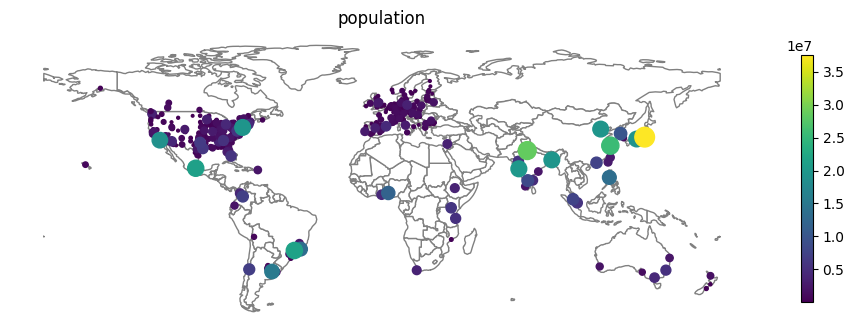

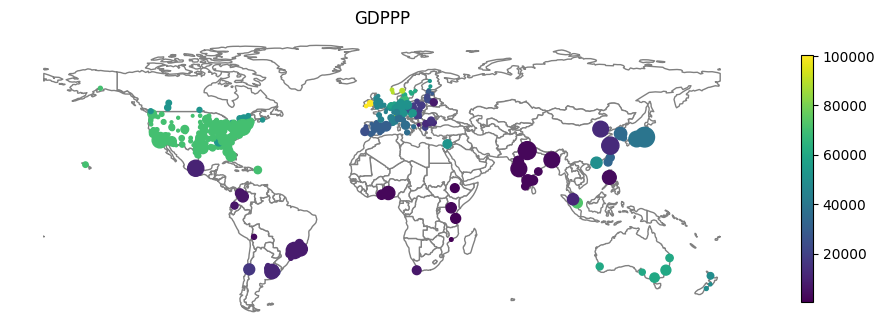

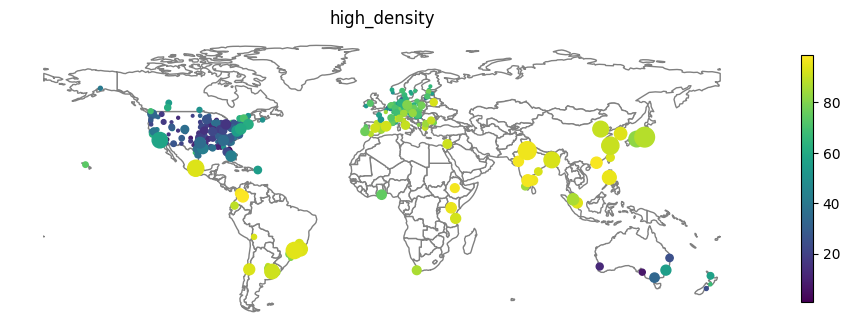

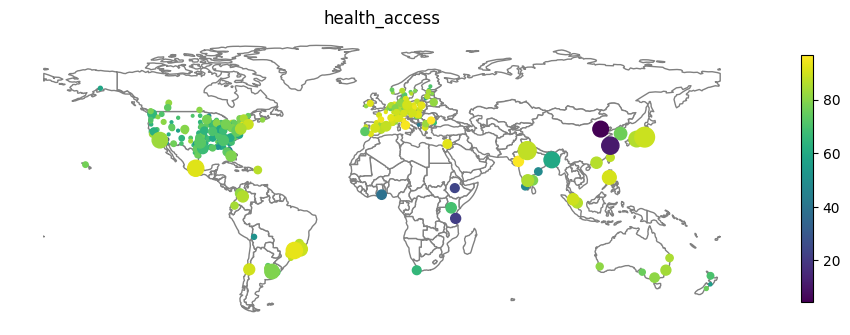

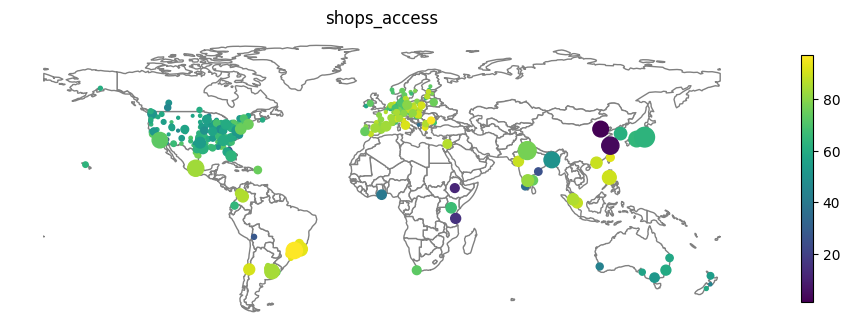

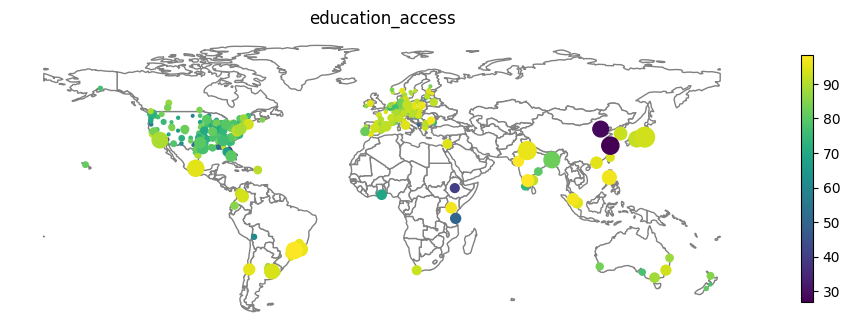

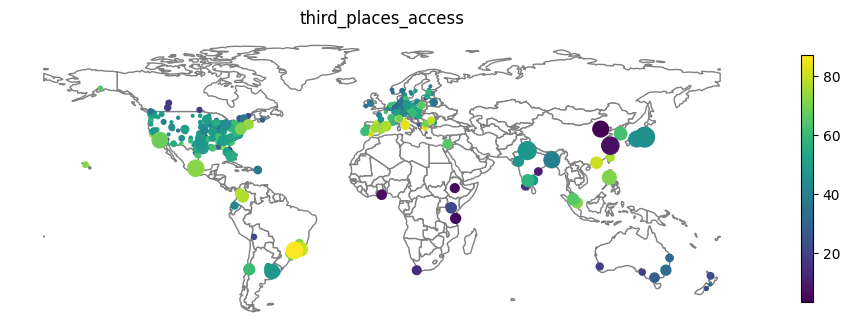

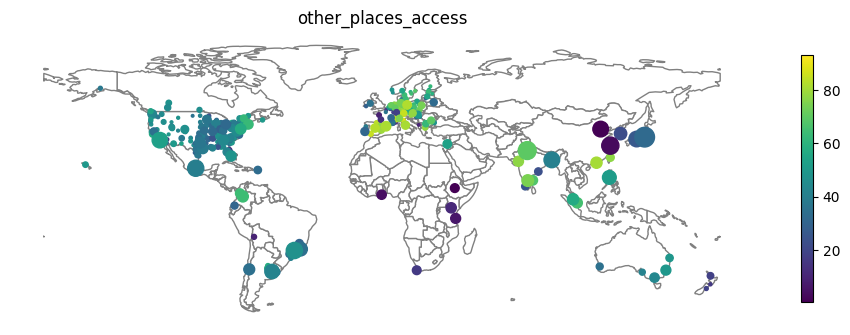

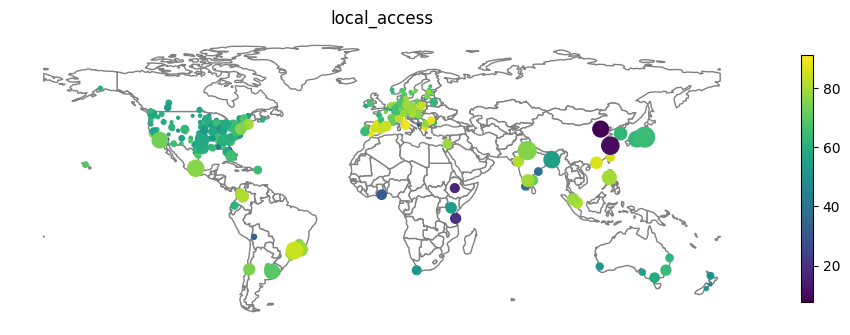

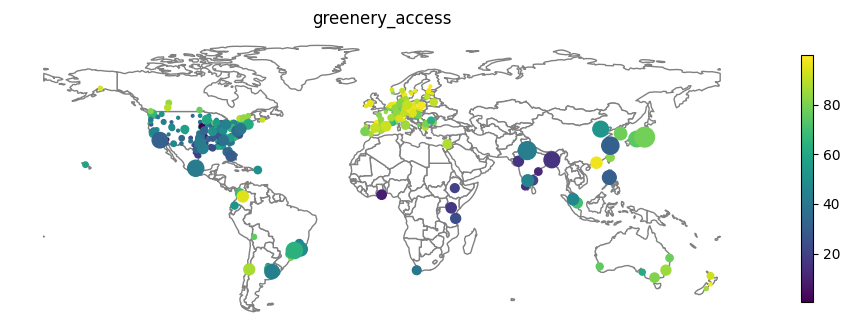

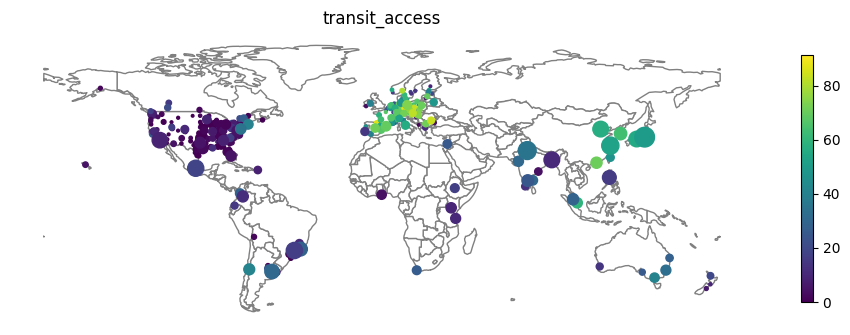

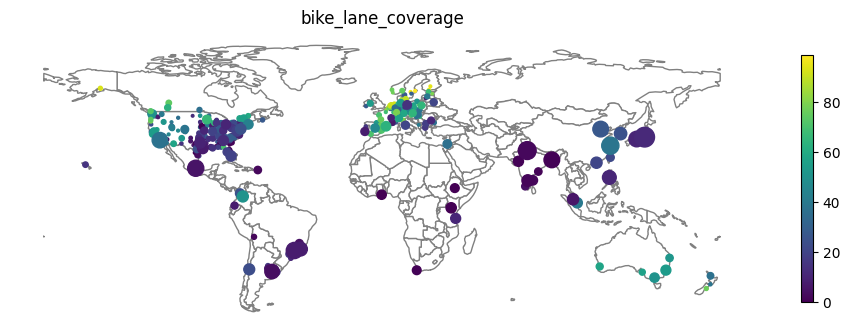

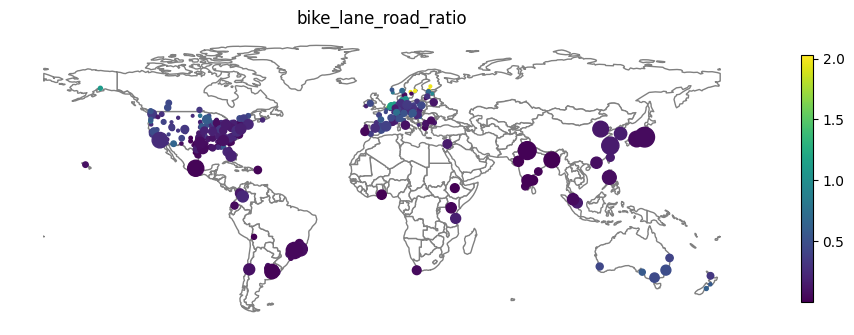

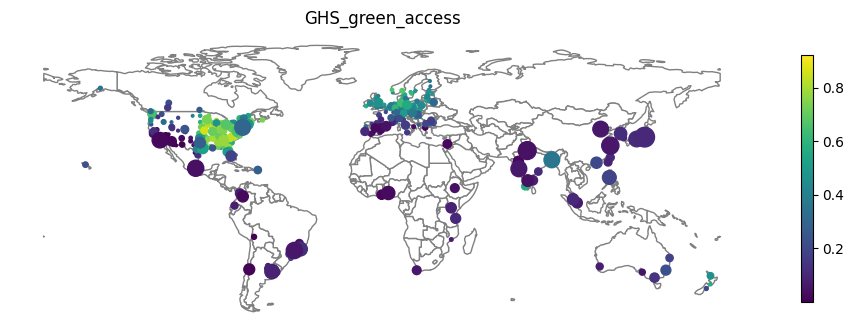

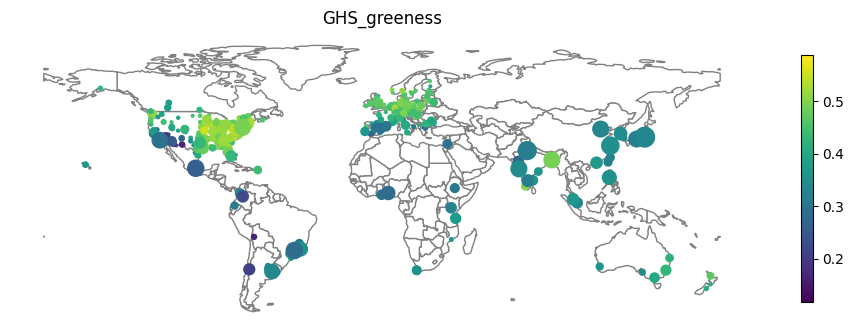

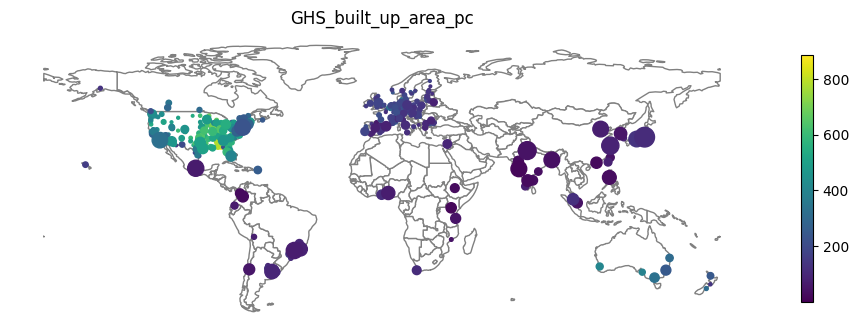

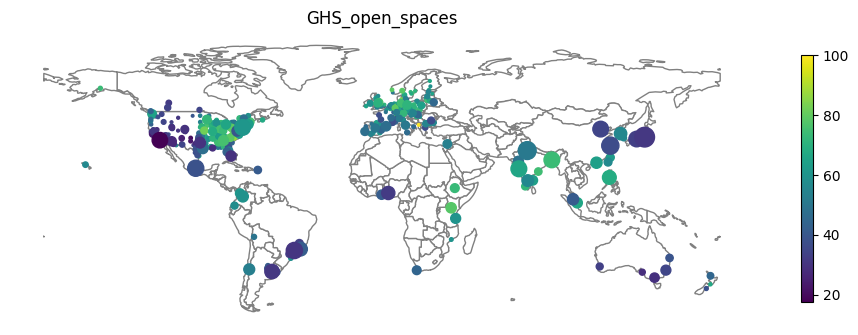

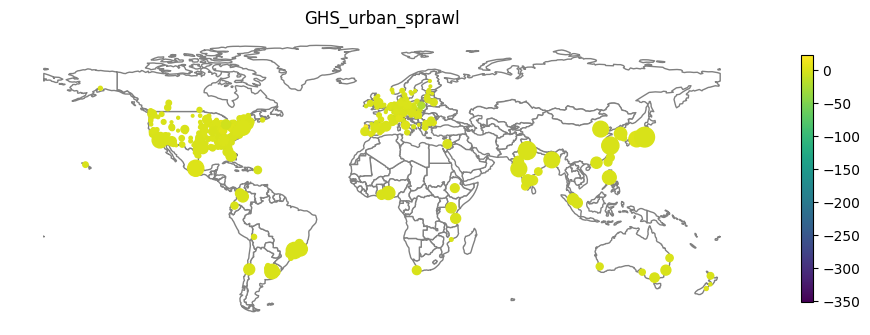

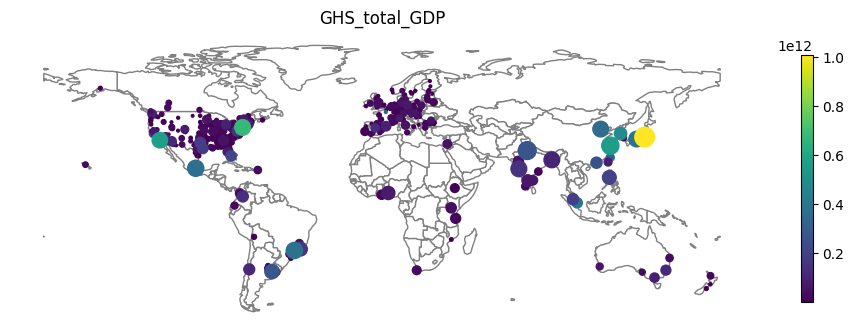

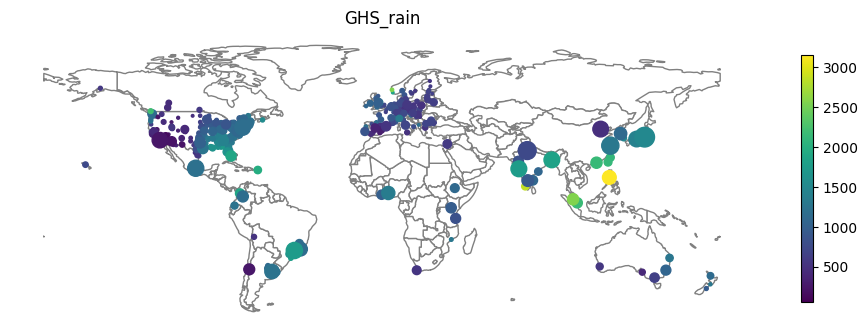

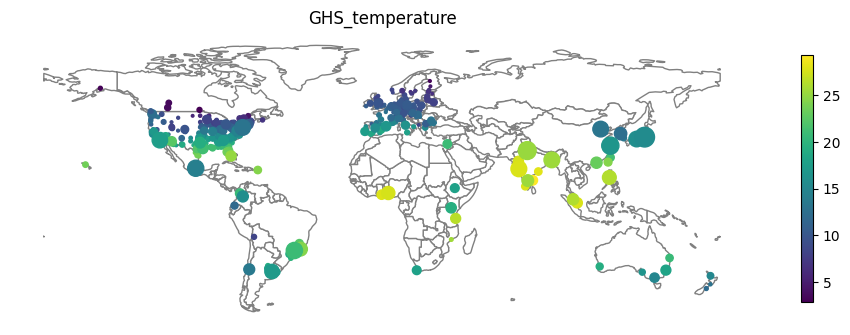

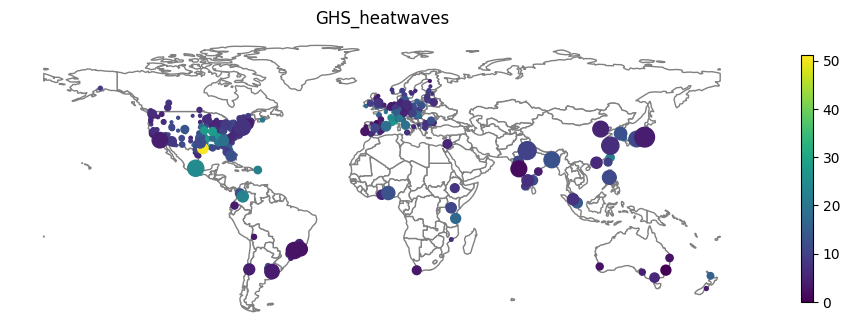

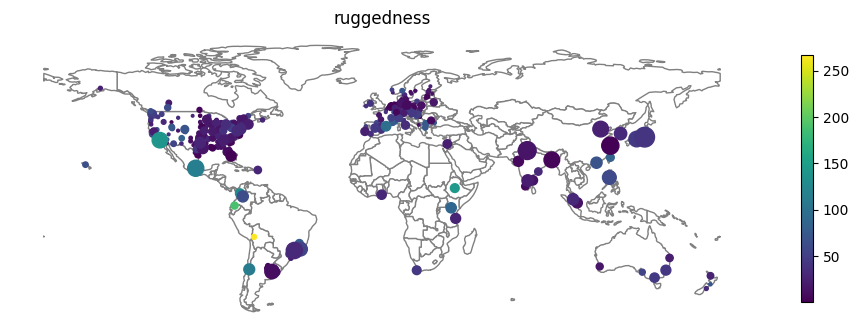

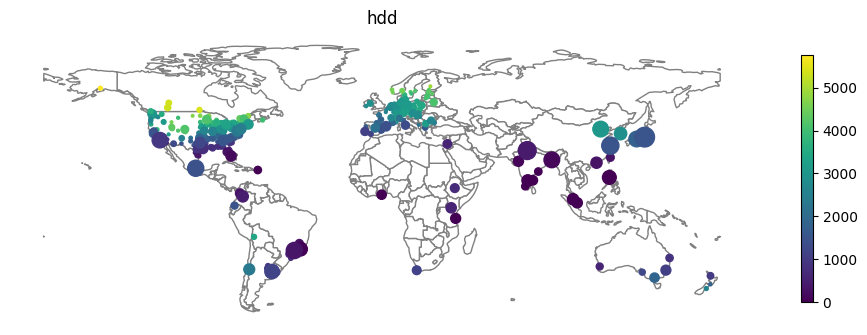

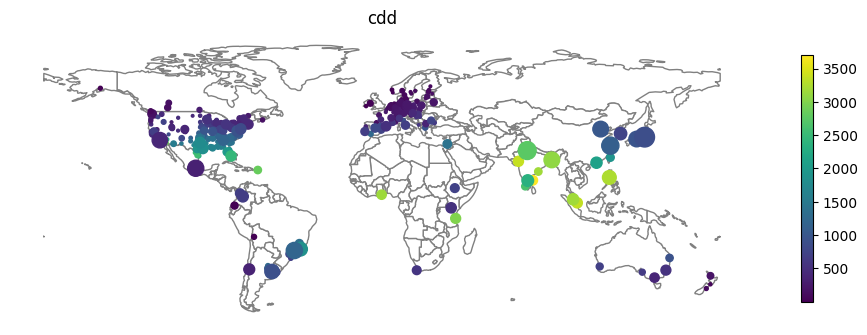

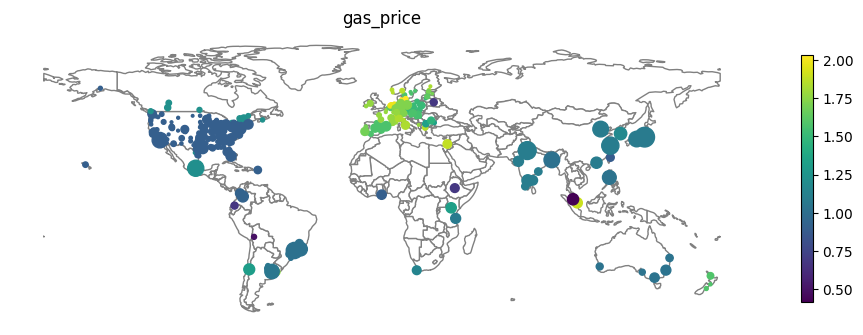

In [217]:
cities_w_fts['GHS_urban_sprawl'] = cities_w_fts['GHS_urban_sprawl'].astype(float)
for ft in fts:
    plot_on_world_map(cities_w_fts.set_geometry('geometry'), ft)